In [1]:
import pandas as pd
import numpy as np

berichtinteracties_met_sentiment = pd.read_csv("Datasets/berichtinteracties_met_sentiment.csv",sep=';')
evenementaanwezigheid = pd.read_csv("Datasets/evenementaanwezigheid.csv",sep=';')
evenementinformatie = pd.read_csv("Datasets/evenementinformatie.csv",sep=';')
gebruikersinformatie = pd.read_csv("Datasets/gebruikersinformatie.csv",sep=';')


berichtinteracties_met_sentiment = berichtinteracties_met_sentiment.drop_duplicates()
evenementaanwezigheid = evenementaanwezigheid.drop_duplicates()
evenementinformatie = evenementinformatie.drop_duplicates()
gebruikersinformatie = gebruikersinformatie.drop_duplicates()


In [2]:
gebruikersinformatie['RegistratieDatum'] = pd.to_datetime(gebruikersinformatie['RegistratieDatum'], format='%d-%m-%Y', errors='coerce')
gebruikersinformatie['LaatsteLogin'] = pd.to_datetime(gebruikersinformatie['LaatsteLogin'], format='%d-%m-%Y', errors='coerce')

true_rows = gebruikersinformatie['RegistratieDatum'] > gebruikersinformatie['LaatsteLogin']

print(true_rows)

0      False
1      False
2      False
3      False
4      False
       ...  
315    False
316    False
317    False
318    False
319    False
Length: 320, dtype: bool


In [98]:
int(gebruikersinformatie["Leeftijd"].mean())

gebruikersinformatie["Leeftijd"] = gebruikersinformatie["Leeftijd"].fillna(int(gebruikersinformatie["Leeftijd"].mean()))


gebruikersinformatie["Lidmaatschapstype"] = gebruikersinformatie["Lidmaatschapstype"].apply(
    lambda x: "Regulier" if x == "x" else x
)


# moot no bij gebruikersinformatie Lidmaatschapstype ale x weghallen en knre naber gebrijken  


In [99]:
gebruikersinformatie['Studierichting'] = gebruikersinformatie['Studierichting'].str.strip().str.lower()

# Optioneel: Als je liever een hoofdletter aan het begin van elk woord wilt (zoals 'Economie' in plaats van 'economie')
gebruikersinformatie['Studierichting'] = gebruikersinformatie['Studierichting'].str.title()


In [100]:
# Filter rows where conditions are met
merged_data = pd.merge(
    evenementaanwezigheid,
    berichtinteracties_met_sentiment,
    on=["EvenementID", "GebruikerID"],
    how="inner"  # Alleen rijen die overeenkomen worden behouden
)


In [101]:
even = evenementaanwezigheid.drop_duplicates()
newdata = even[even["Aanwezigheidsstatus"] == "Afwezig"]
print(newdata)



grouped_data = even.groupby(["EvenementID", "GebruikerID"]).agg(
    Count=("Aanwezigheidsstatus", "size"),  # Aantal rijen per groep
    AanwezigheidsstatusList=("Aanwezigheidsstatus", list)  # Lijst van Aanwezigheidsstatus
).reset_index()

duplicates = grouped_data[grouped_data["Count"] > 1]
is_Afwezig = duplicates[duplicates["AanwezigheidsstatusList"].apply(lambda x: "Afwezig" in x and "Bijgewoond" in x)]

print(is_Afwezig)



     EvenementID GebruikerID Aanwezigheidsstatus
0           E003        G131             Afwezig
1           E016        G127             Afwezig
2           E034        G309             Afwezig
6           E026        G060             Afwezig
21          E018        G196             Afwezig
...          ...         ...                 ...
3952        E005        G132             Afwezig
3953        E022        G041             Afwezig
3954        E009        G222             Afwezig
3960        E001        G316             Afwezig
3977        E037        G093             Afwezig

[755 rows x 3 columns]
Empty DataFrame
Columns: [EvenementID, GebruikerID, Count, AanwezigheidsstatusList]
Index: []


In [102]:
evenementaanwezigheid = evenementaanwezigheid[
    ~(
        (evenementaanwezigheid["EvenementID"].isin(is_Afwezig["EvenementID"])) &
        (evenementaanwezigheid["GebruikerID"].isin(is_Afwezig["GebruikerID"])) &
        (evenementaanwezigheid["Aanwezigheidsstatus"] == "Afwezig")
    )
]
print(evenementaanwezigheid)

     EvenementID GebruikerID Aanwezigheidsstatus
0           E003        G131             Afwezig
1           E016        G127             Afwezig
2           E034        G309             Afwezig
3           E020        G297          Bijgewoond
5           E032        G007          Bijgewoond
...          ...         ...                 ...
3993        E024        G116          Bijgewoond
3994        E002        G010       Geregistreerd
3995        E010        G167       Geregistreerd
3997        E039        G033          Bijgewoond
3998        E030        G314          Bijgewoond

[3321 rows x 3 columns]


In [104]:
# newdata = merged_data[merged_data["Aanwezigheidsstatus"] == "Afwezig"]
# print(newdata)



grouped_data = merged_data.groupby(["EvenementID", "GebruikerID"]).agg(
    Count=("Aanwezigheidsstatus", "size"),  # Aantal rijen per groep
    AanwezigheidsstatusList=("Aanwezigheidsstatus", list),  # Lijst van Aanwezigheidsstatus
).reset_index()

duplicates = grouped_data[grouped_data["Count"] > 0]
is_Afwezig = duplicates[duplicates["AanwezigheidsstatusList"].apply(lambda x: len(set(x))==1 and "Afwezig" in x)]

print(is_Afwezig)

Empty DataFrame
Columns: [EvenementID, GebruikerID, Count, AanwezigheidsstatusList]
Index: []


In [105]:
result = pd.merge(is_Afwezig, berichtinteracties_met_sentiment, on=["EvenementID", "GebruikerID"], how="inner")

print(result)



Empty DataFrame
Columns: [EvenementID, GebruikerID, Count, AanwezigheidsstatusList, BerichtID, BerichtDatum, BerichtSentiment, OntvangenLikes, OntvangenReacties]
Index: []


In [106]:

berichtinteracties_met_sentiment = berichtinteracties_met_sentiment[
    ~(
        (berichtinteracties_met_sentiment["EvenementID"].isin(result["EvenementID"])) &
        (berichtinteracties_met_sentiment["GebruikerID"].isin(result["GebruikerID"]))
    )
]
print(berichtinteracties_met_sentiment)


    BerichtID BerichtDatum GebruikerID EvenementID BerichtSentiment  \
0        B001    18-5-2023        G309        E012         Neutraal   
1        B002    6-10-2023        G021        E039         Positief   
2        B003     7-7-2023        G111        E001         Positief   
3        B004    5-10-2023        G168        E015         Negatief   
4        B005    22-1-2023        G076        E017         Neutraal   
..        ...          ...         ...         ...              ...   
494      B495     3-3-2023        G210        E025         Positief   
495      B496    16-2-2023        G263        E010         Neutraal   
497      B498   18-12-2023        G005        E004         Positief   
498      B499     5-6-2023        G243        E013         Positief   
499      B500   27-12-2023        G068        E018         Positief   

     OntvangenLikes  OntvangenReacties  
0                 5                  8  
1                 9                  6  
2                 8     

In [107]:

newdata = merged_data[merged_data["Aanwezigheidsstatus"] == "Afwezig"]

print(newdata)

   EvenementID GebruikerID Aanwezigheidsstatus BerichtID BerichtDatum  \
4         E013        G244             Afwezig      B416     6-5-2023   
31        E003        G196             Afwezig      B055    22-5-2023   
74        E007        G284             Afwezig      B270   18-11-2023   
89        E022        G160             Afwezig      B422    5-10-2023   
95        E029        G242             Afwezig      B302     3-5-2023   

   BerichtSentiment  OntvangenLikes  OntvangenReacties  
4          Neutraal              10                  3  
31         Positief              17                  6  
74         Positief               4                  1  
89         Positief              18                  7  
95         Positief               6                  4  


In [108]:
berichtinteracties_met_sentiment
evenementaanwezigheid 
evenementinformatie
gebruikersinformatie
data = pd.merge(berichtinteracties_met_sentiment, evenementaanwezigheid, on=['EvenementID', 'GebruikerID'])
data = pd.merge(data, evenementinformatie, on='EvenementID')
data = pd.merge(data, gebruikersinformatie, on='GebruikerID')


C:\Users\Stefa\AppData\Local\Temp\ipykernel_21408\253058008.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['EvenementDatum'] = pd.to_datetime(data['EvenementDatum'])


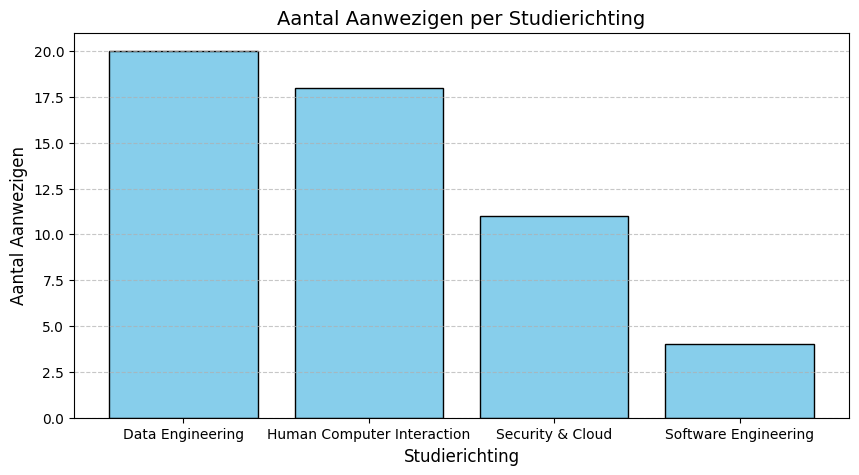

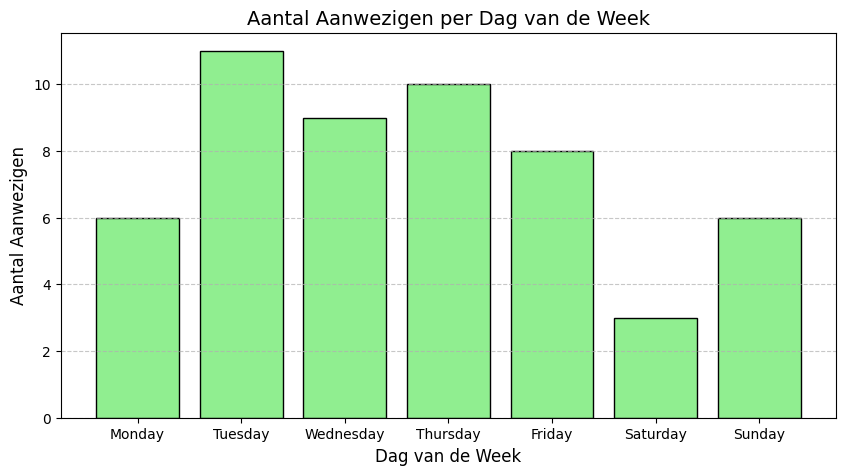

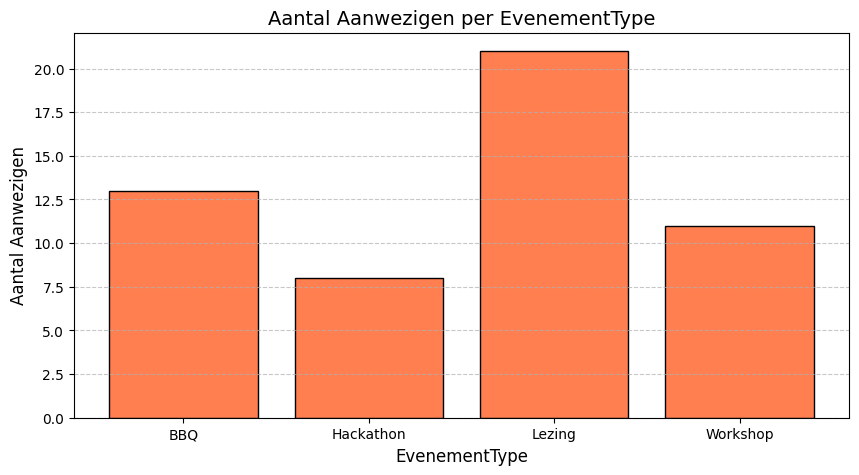

In [109]:
# Zorg ervoor dat de datumkolommen datetime objects zijn
data['EvenementDatum'] = pd.to_datetime(data['EvenementDatum'])

# Voeg een kolom toe voor de dag van de week
data['DagVanDeWeek'] = data['EvenementDatum'].dt.day_name()

# --- Analyse op Studierichting ---
# Gemiddelde opkomst per opleiding
studierichting_opkomst = data.groupby('Studierichting')['Aanwezigheidsstatus'].apply(lambda x: (x == 'Bijgewoond').sum()).reset_index()
studierichting_opkomst.columns = ['Studierichting', 'Aantal Aanwezigen']

# --- Analyse op Dag van de Week ---
# Gemiddelde opkomst per dag van de week
dag_opkomst = data.groupby('DagVanDeWeek')['Aanwezigheidsstatus'].apply(lambda x: (x == 'Bijgewoond').sum()).reset_index()
dag_opkomst.columns = ['DagVanDeWeek', 'Aantal Aanwezigen']

# Sorteer de dagen van de week
dag_volgorde = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dag_opkomst['DagVanDeWeek'] = pd.Categorical(dag_opkomst['DagVanDeWeek'], categories=dag_volgorde, ordered=True)
dag_opkomst = dag_opkomst.sort_values('DagVanDeWeek')

# --- Visualisaties ---
# 1. Visualiseer opkomst per opleiding
plt.figure(figsize=(10, 5))
plt.bar(studierichting_opkomst['Studierichting'], studierichting_opkomst['Aantal Aanwezigen'], color='skyblue', edgecolor='black')
plt.title('Aantal Aanwezigen per Studierichting', fontsize=14)
plt.xlabel('Studierichting', fontsize=12)
plt.ylabel('Aantal Aanwezigen', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Visualiseer opkomst per dag van de week
plt.figure(figsize=(10, 5))
plt.bar(dag_opkomst['DagVanDeWeek'], dag_opkomst['Aantal Aanwezigen'], color='lightgreen', edgecolor='black')
plt.title('Aantal Aanwezigen per Dag van de Week', fontsize=14)
plt.xlabel('Dag van de Week', fontsize=12)
plt.ylabel('Aantal Aanwezigen', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Analyse op EvenementType ---
# Groepeer de data per EvenementType en bereken het aantal aanwezigen
evenementtype_opkomst = data.groupby('EvenementType')['Aanwezigheidsstatus'].apply(lambda x: (x == 'Bijgewoond').sum()).reset_index()
evenementtype_opkomst.columns = ['EvenementType', 'Aantal Aanwezigen']

# --- Visualisatie ---
plt.figure(figsize=(10, 5))
plt.bar(evenementtype_opkomst['EvenementType'], evenementtype_opkomst['Aantal Aanwezigen'], color='coral', edgecolor='black')
plt.title('Aantal Aanwezigen per EvenementType', fontsize=14)
plt.xlabel('EvenementType', fontsize=12)
plt.ylabel('Aantal Aanwezigen', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


supervised-learning

In [46]:
from dmba import regressionSummary
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor,plot_tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt

   Ingeschreven  Aanwezig                         Categorie
0             0         1  Niet Geregistreerd maar Aanwezig
1             0         1  Niet Geregistreerd maar Aanwezig
2             0         1  Niet Geregistreerd maar Aanwezig
3             0         1  Niet Geregistreerd maar Aanwezig
4             0         1  Niet Geregistreerd maar Aanwezig
Accuracy: 95.45%
Confusiematrix:
[[ 9  0  0]
 [ 0  0  1]
 [ 0  0 12]]


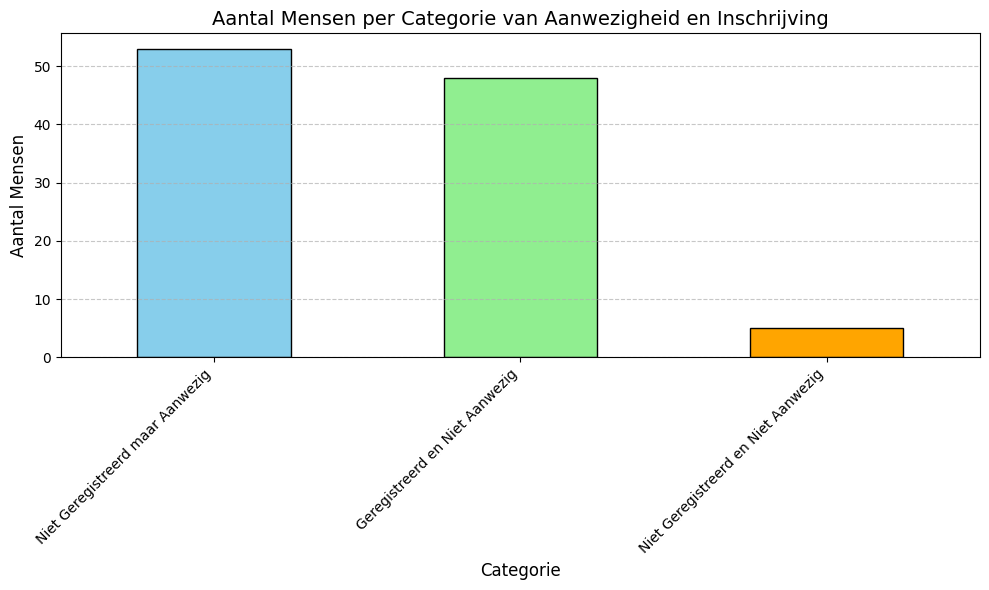

In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Stap 1: Maak de 'Ingeschreven' kolom op basis van 'Aanwezigheidsstatus'
# Als 'Aanwezigheidsstatus' = 'Geregistreerd', beschouwen we de gebruiker als ingeschreven.
data['Ingeschreven'] = data['Aanwezigheidsstatus'].apply(lambda x: 1 if x == 'Geregistreerd' else 0)

# Stap 2: Maak de 'Aanwezig' kolom die aangeeft of de gebruiker daadwerkelijk aanwezig was
# Stel dat we een kolom hebben 'Aanwezigheidsstatus' die aangeeft of iemand aanwezig was (bijv. 'aanwezig', 'afwezig')
data['Aanwezig'] = data['Aanwezigheidsstatus'].apply(lambda x: 1 if x == 'Bijgewoond' else 0)

# Stap 3: Maak een nieuwe 'Categorie' kolom die de vier groepen definieert
data['Categorie'] = data.apply(
    lambda row: 'Geregistreerd en Aanwezig' if row['Ingeschreven'] == 1 and row['Aanwezig'] == 1 else (
        'Geregistreerd en Niet Aanwezig' if row['Ingeschreven'] == 1 and row['Aanwezig'] == 0 else (
            'Niet Geregistreerd en Niet Aanwezig' if row['Ingeschreven'] == 0 and row['Aanwezig'] == 0 else 'Niet Geregistreerd maar Aanwezig'
        )
    ), axis=1
)

# Bekijk de eerste paar rijen om te controleren
print(data[['Ingeschreven', 'Aanwezig', 'Categorie']].head())

# Stap 4: Zet categorische variabelen om naar numerieke waarden
label_encoder = LabelEncoder()
data['Studierichting'] = label_encoder.fit_transform(data['Studierichting'])
data['EvenementType'] = label_encoder.fit_transform(data['EvenementType'])
data['Lidmaatschapstype'] = label_encoder.fit_transform(data['Lidmaatschapstype'])

# Stap 5: Kenmerken en doelvariabele
X = data[['Ingeschreven', 'Leeftijd', 'Studierichting', 'EvenementType', 'Lidmaatschapstype']]
y = data['Categorie']  # Doelvariabele (Categorie)

# Stap 6: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Stap 7: Train een Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Stap 8: Voorspel de aanwezigheid en inschrijving
y_pred = model.predict(X_test)

# Stap 9: Evalueren
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusiematrix om te zien hoeveel correct voorspeld is
print("Confusiematrix:")
print(confusion_matrix(y_test, y_pred))

# Stap 10: Voorspellen van nieuwe data
# Voorbeeld: Een gebruiker die is geregistreerd (Ingeschreven=1), leeftijd 22, studierichting 2, EvenementType 1, Lidmaatschapstype 0
import matplotlib.pyplot as plt

# Stap 1: Groepeer de data per 'Categorie' en tel het aantal mensen per categorie
categorie_opkomst = data['Categorie'].value_counts()

# Stap 2: Maak een staafdiagram van de opkomst per categorie
plt.figure(figsize=(10, 6))
categorie_opkomst.plot(kind='bar', color=['skyblue', 'lightgreen', 'orange', 'salmon'], edgecolor='black')

# Stap 3: Voeg titels en labels toe
plt.title('Aantal Mensen per Categorie van Aanwezigheid en Inschrijving', fontsize=14)
plt.xlabel('Categorie', fontsize=12)
plt.ylabel('Aantal Mensen', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Stap 4: Toon de plot
plt.tight_layout()
plt.show()



KeyError: "['Aantal Berichten'] not in index"

unsupervised-learning